### PCA 

In [1]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from copy import *

%load_ext autoreload
%autoreload 2

In [2]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20 # change to set one

In [3]:
# filter data with the minimum reviews
filtered_avis = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_avis)

11201 10549
1259 1267
904 1158
873 1140
869 1136
868 1135


In [4]:
# not centered version 
user_game_ratings.shape

(868, 1135)

In [5]:
# calculate the covariance matrix on the centered data
# take eigenvectors and values of this cov matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scale the data
scaled_df = StandardScaler().fit_transform(user_game_ratings.todense()) # scale our matrix, values - mean / std

In [6]:
# reducing the number of components
pca = PCA(n_components=2) 
components = pca.fit_transform(scaled_df)

In [7]:
pca.explained_variance_ratio_ # very low for this

array([0.05849994, 0.03310563])

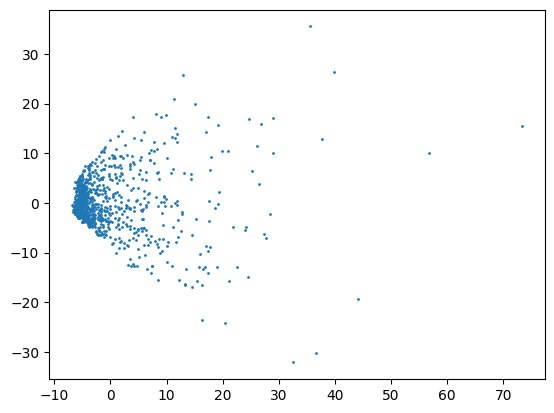

In [8]:
plt.scatter(components[:, 0], components[:, 1], s=1)

In [9]:
# test with another matrix
# take matrix user and game caracteristic

In [10]:
# first choose the most popular game categories NO CAPITALIZE
categories = jeux_clean["Type"].str.split(r'[|/]').dropna()
lst_categories = np.unique([item.strip() for list_items in categories for item in list_items])
lst_categories, len(lst_categories)

(array(['Abstrait', 'Adresse', 'Affrontement', 'Afrique', 'Alignement',
        'Amateur', 'Ambiance', 'Animaux', 'Antiquité', 'Archive', 'Art',
        'Asie', 'Astronomie et Espace', 'Autres', 'Avant-vente',
        'Aventures dans la jungle', 'Aviation', 'Bande dessinée',
        'Blocage', 'Bluff', 'Bourse & finances', 'Cambriolage', 'Capture',
        'Card-driven', 'Cartes à jouer', 'Casse-tête', 'Casual',
        'Catastrophe', 'Chant & Danse', 'Chat', 'Chiffres', 'Chifoumi',
        'Choix simultanés', 'Cirque', 'Cochon', 'Collection',
        'Colonisation', 'Combinaison', 'Commerce', 'Connaissances',
        'Connexions', 'Conquête', 'Construction',
        'Contes, Mythes & Légendes', 'Coopération', 'Course', 'Créativité',
        'Cuisine', 'Cyberpunk', 'Cyclisme', 'Deck building', 'Desert',
        'Dessin', 'Devinette', 'Dextérité', 'Diplomatie', 'Divers',
        'Draft', 'Duplicate', 'Déduction', 'Défausse', 'Déplacement',
        'Dés', 'Echange - troc', 'Ecologie', 'E

In [11]:
# for each categories the number of games
count_cat = np.array([[category, int(jeux_clean['Type'].str.contains(category, na=False, regex=False).sum())] for category in lst_categories])
# two best categories
sorted_categ = count_cat[count_cat[:,1].astype(int).argsort()[::-1]]
sorted_categ

array([['Jeux de plateau', '3163'],
       ['Jeux de cartes', '1742'],
       ['Jeux de guerre', '444'],
       ['Affrontement', '427'],
       ['Autres', '397'],
       ['Placement', '396'],
       ['Gestion', '395'],
       ['Médiéval', '379'],
       ['Hasard (Dé, Cartes, ...)', '363'],
       ['Jeux de figurines', '301'],
       ['Casse-tête', '297'],
       ['Combinaison', '263'],
       ['Déplacement', '257'],
       ['Ambiance', '250'],
       ['Jeux de pions', '244'],
       ['Médiéval-fantastique', '239'],
       ['Dés', '232'],
       ['Guerre', '226'],
       ['Coopération', '210'],
       ['Gestion de main', '204'],
       ['Animaux', '185'],
       ['Exploration', '185'],
       ['Jeu de carte à collectionner', '184'],
       ['Jeux de connaissances', '180'],
       ['Bluff', '179'],
       ['Fantastique', '172'],
       ['Majorité', '161'],
       ['Jeux de dés', '160'],
       ['Jeu de logique', '157'],
       ['Science fiction', '153'],
       ['Prise de risque', '153']

In [12]:
#  for each cat, the game ids for sorted df
jeux_nonan = jeux_clean.dropna()
jeux_nonan = jeux_nonan[jeux_nonan["Game id"].isin(filtered_avis["Game id"].unique())]
cat_games = [[cat, list(jeux_nonan.loc[jeux_nonan['Type'].str.lower().str.contains(cat.lower(), na=False, regex=False)]["Game id"])] for cat in lst_categories]
ar_cat_games = np.array(cat_games, dtype=object)[:,1]

In [13]:
# associated index game
game_ids = pd.Series(np.unique(np.concatenate(ar_cat_games)).astype(int)) # game ids concerned for matrix
# associated index users 
users_id = pd.Series(np.unique(filtered_avis["User id"]))

In [14]:
game_ids.shape, users_id.shape

((842,), (868,))

In [247]:
# using pivot table -> separate | into many rows, after counting the categories
# merge the databases
avis_jeux = jeux_nonan[["Game id", "Type"]].merge(filtered_avis[["User id", "Game id", "Rating"]], on='Game id')

# for each category create a new row
types = avis_jeux['Type'].str.split(r'[|/]').explode()
user_game_type = pd.DataFrame({
    'User id': avis_jeux['User id'].repeat(avis_jeux['Type'].str.split(r'[|/]').apply(len)),
    'Game id': avis_jeux['Game id'].repeat(avis_jeux['Type'].str.split(r'[|/]').apply(len)),
    'Type': types
}).drop_duplicates()


In [250]:
user_type = user_game_type[["User id", "Type"]].drop_duplicates().pivot_table(index ="User id", columns="Type", aggfunc='size', fill_value=0)
user_type

Type,famille,mots,Abstrait,Adresse,Affrontement,Afrique,Alignement,Amateur,Ambiance,Animaux,...,Taquin,Toucher,Trahison,Transport de marchandise,Tuile,Ville,Volcan,Vote,Zombies,équipe
User id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,1,0,0,1,0
1,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,0,0,0,1,1,...,1,0,1,1,1,1,1,0,0,0
3,1,1,0,1,1,0,1,0,1,1,...,1,0,1,1,1,1,1,0,1,1
6,1,0,1,1,0,0,0,0,0,1,...,0,0,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,1,0,0,0,0,1,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
6818,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6961,0,0,0,1,1,0,0,0,1,1,...,1,0,1,0,0,0,0,0,1,0


In [251]:
game_type = user_game_type[["Game id", "Type"]].drop_duplicates().pivot_table(index ="Game id", columns="Type", aggfunc='size', fill_value=0)
game_type

Type,famille,mots,Abstrait,Adresse,Affrontement,Afrique,Alignement,Amateur,Ambiance,Animaux,...,Taquin,Toucher,Trahison,Transport de marchandise,Tuile,Ville,Volcan,Vote,Zombies,équipe
Game id,,,,,,,,,,,,,,,,,,,,,
15,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
from sklearn.cluster import KMeans

# clustering the users
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3)  
clustered = kmeans.fit_predict(user_type)

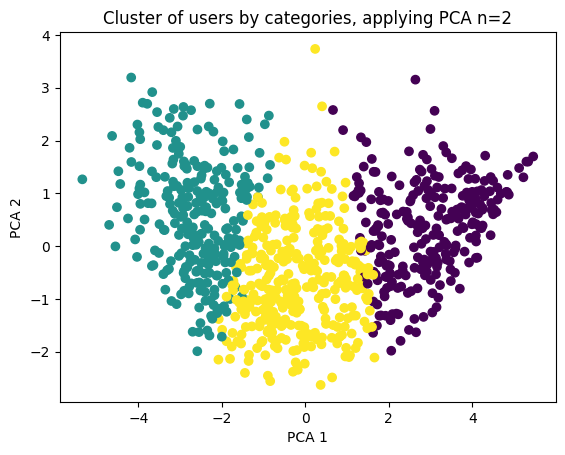

In [300]:
# apply PCA to see the clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
user_type_2d = pca.fit_transform(user_type)

# plot
plt.scatter(user_type_2d[:,0], user_type_2d[:,1], c=clustered)
plt.title("Cluster of users by categories, applying PCA n=2")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

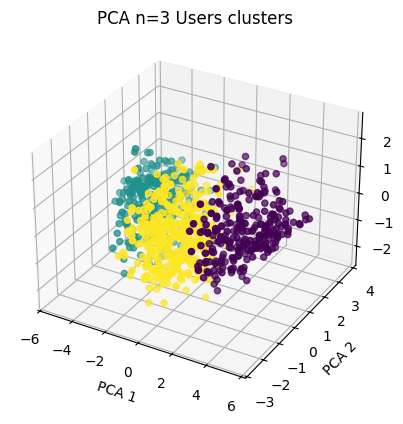

In [301]:
# visualisation in 3D
pca = PCA(n_components=3)
user_type_2d = pca.fit_transform(user_type)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(user_type_2d[:,0], user_type_2d[:,1], user_type_2d[:,2], c=clustered)

ax.set_title("PCA n=3 Users clusters")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

In [302]:
# clustering the games
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2)  
clustered = kmeans.fit_predict(game_type)
clustered.shape, game_type.shape

((842,), (842, 158))

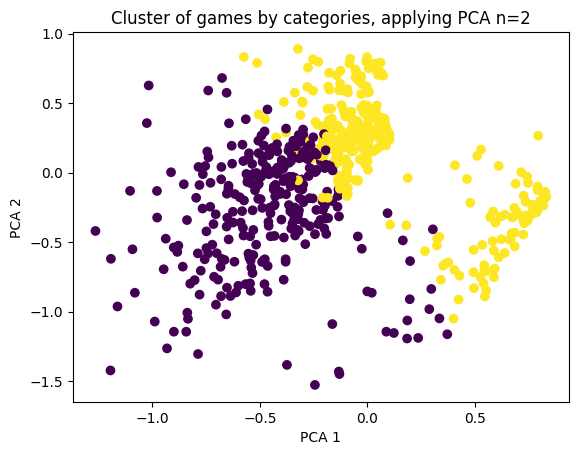

In [303]:
# apply PCA to see the clusters
pca = PCA(n_components=2)
game_type_2d = pca.fit_transform(game_type)

# plot
plt.scatter(game_type_2d[:,0], game_type_2d[:,1], c=clustered)
plt.title("Cluster of games by categories, applying PCA n=2")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

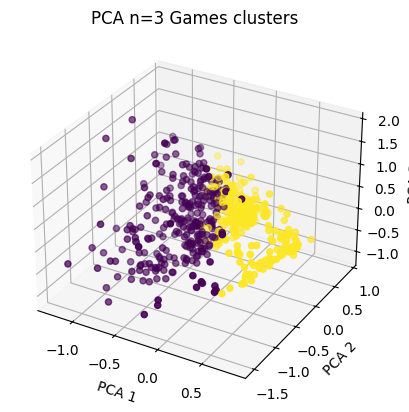

In [304]:
# visualisation in 3D
pca = PCA(n_components=3)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(game_type_2d[:,0], game_type_2d[:,1], game_type_2d[:,2], c=clustered)
ax.set_title("PCA n=3 Games clusters")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

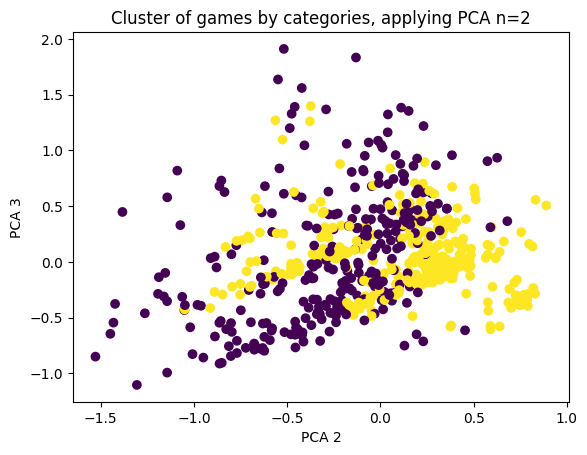

In [306]:
# PCA 3 visualisez in different parts
# plot
plt.scatter(game_type_2d[:,1], game_type_2d[:,2], c=clustered)
plt.title("Cluster of games by categories, applying PCA n=2")
plt.xlabel("PCA 2")
plt.ylabel("PCA 3")
plt.show()

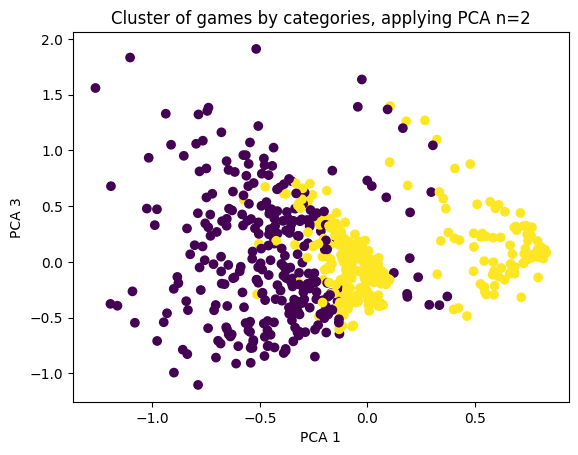

In [307]:
# PCA 3 visualisez in different parts
# plot
plt.scatter(game_type_2d[:,0], game_type_2d[:,2], c=clustered)
plt.title("Cluster of games by categories, applying PCA n=2")
plt.xlabel("PCA 1")
plt.ylabel("PCA 3")
plt.show()

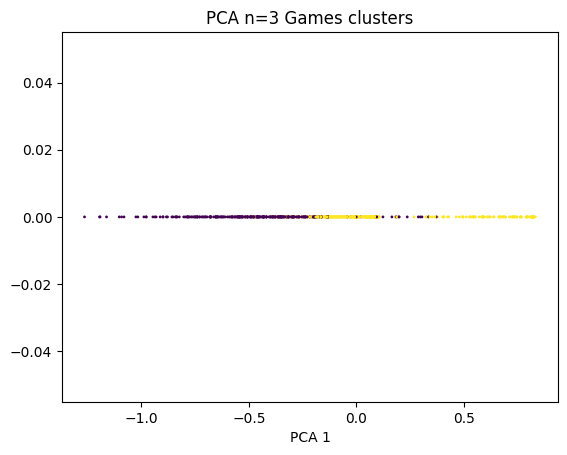

In [ ]:
# visualisation in 3D
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.scatter(game_type_2d, np.zeros(len(game_type_2d)),c=clustered, s=1)
plt.title("PCA n=3 Games clusters")
plt.xlabel('PCA 1')

plt.show()

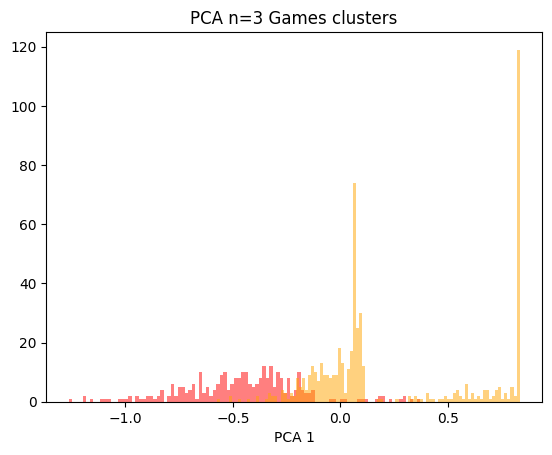

In [327]:
# visualisation in 3D
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.hist(game_type_2d[np.where(clustered == 0)[0]], bins=100, color="red", alpha=0.5)
plt.hist(game_type_2d[np.where(clustered == 1)[0]], bins=100, color="orange", alpha=0.5)
plt.title("PCA n=3 Games clusters")
plt.xlabel('PCA 1')

plt.show()

In [ ]:
class0 = np.where(clustered == 0)[0]
class1 = np.where(clustered == 1)[0]

array([[-2.31405440e-01],
       [-7.39861677e-02],
       [-1.36803793e-01],
       [ 8.20250180e-01],
       [ 8.20250180e-01],
       [-1.35824853e-01],
       [ 7.16819245e-01],
       [ 8.20250180e-01],
       [ 8.20250180e-01],
       [-2.08972327e-01],
       [ 8.55748744e-02],
       [-2.83584172e-02],
       [ 6.40914547e-02],
       [ 6.40914547e-02],
       [ 8.20250180e-01],
       [ 4.44212283e-02],
       [-1.30893335e-01],
       [-1.24483281e-01],
       [-3.88184750e-01],
       [ 5.89309110e-01],
       [ 6.39366676e-01],
       [-1.21678975e-01],
       [-4.35137572e-02],
       [ 5.96631327e-01],
       [ 8.20250180e-01],
       [-2.24692274e-01],
       [ 8.20250180e-01],
       [ 8.20250180e-01],
       [ 7.28197820e-01],
       [ 8.20250180e-01],
       [ 8.20250180e-01],
       [ 4.94378413e-01],
       [ 8.20250180e-01],
       [ 7.46573915e-01],
       [ 8.20250180e-01],
       [ 8.10527538e-02],
       [ 1.02290587e-01],
       [ 3.24385850e-01],
       [-1.8

In [ ]:
# verify the matrix is working okay
# tmp2[tmp2["User id"] == 0]['Type'].unique().shape
# np.unique([el for sub in avis_jeux[avis_jeux["User id"] == 0]["Type"].str.split(r'[|/]').tolist() for el in sub]).shape
# user_type.loc[0].sum()
# len(user_game_type[user_game_type["User id"] == 1]["Type"].unique())